## CREDIT CARD FRAUD

## 1.0 EDA

Firstly we need to import the necessary libraries and configure the Spark session. After that, we load our data set, in order to analyse it, and perform EDA.

In [17]:
#Import libraries and configure spark session
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
from scipy import stats
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

import pyspark.sql.functions as f
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("xpto7") \
    .getOrCreate()
sc = spark.sparkContext

In [18]:
# Load file
df = spark.read.csv('datasets/creditcard.csv', header=True, inferSchema=True, sep=",")

# Print Schema
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

It appears that the dataset has a total of 31 columns, in which 28 of them are components that are results of PCA. Columns V1-V28 are going to be more abstract, since we don't have a clear definition/description of what they represent.

In [19]:
df.head()

Row(Time=0.0, V1=-1.3598071336738, V2=-0.0727811733098497, V3=2.53634673796914, V4=1.37815522427443, V5=-0.338320769942518, V6=0.462387777762292, V7=0.239598554061257, V8=0.0986979012610507, V9=0.363786969611213, V10=0.0907941719789316, V11=-0.551599533260813, V12=-0.617800855762348, V13=-0.991389847235408, V14=-0.311169353699879, V15=1.46817697209427, V16=-0.470400525259478, V17=0.207971241929242, V18=0.0257905801985591, V19=0.403992960255733, V20=0.251412098239705, V21=-0.018306777944153, V22=0.277837575558899, V23=-0.110473910188767, V24=0.0669280749146731, V25=0.128539358273528, V26=-0.189114843888824, V27=0.133558376740387, V28=-0.0210530534538215, Amount=149.62, Class=0)

In [20]:
#Shape of the Dataframe
print((df.count(), len(df.columns)))

(284807, 31)


After performing the counts above, we conclude that we are going to be working with a dataset that has 284 807 rows.

In [21]:
df.toPandas().info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [22]:
df.toPandas().head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [23]:
#statistics
df.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.918649e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.682686e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.761736e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.811118e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552103e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.040130e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.698953e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.958151e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.147640e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


The maximum amount of time (in seconds) recorded between transactions is 172792 seconds, which is equivalent to 2880 minutes, or approx. 48 hours. We can also conclude that the maximum value for Amount is $ 25691.16.

## 1.1 CHECKING MISSING VALUES

In [24]:
#Check missing and null data
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Above checked for missing values. Each column shows the amount of null or NaN values in each column. It appears that the dataset doesn't have missing values!

## HOW MANY ROWS IN THE DATASET REPRESENT CREDIT CARD FRAUD?

In [25]:
#Number of Frauds and non-frauds
classFreq = df.groupBy("Class").count()
classFreq.show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



In [26]:
total = classFreq.select("count").agg({"count": "sum"}).collect().pop()['sum(count)']
result = classFreq.withColumn('percent', (classFreq['count']/total) * 100)
result.show()

+-----+------+------------------+
|Class| count|           percent|
+-----+------+------------------+
|    1|   492|0.1727485630620034|
|    0|284315| 99.82725143693798|
+-----+------+------------------+



Here we can see that, out of the 284 807 rows of information available, 492 represent credit card fraud, which translates to approx. 17% of the records. With these results, it is safe to say that we have an unbalanced dataset.

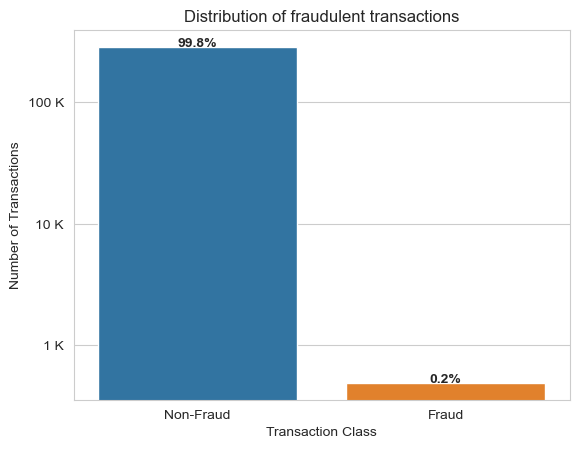

In [27]:
fraud_df = df.select("Class").toPandas()

# Count the number of transactions for each class (fraudulent or not)
fraud_counts = fraud_df['Class'].value_counts()

# Calculate the percentage of each class
fraud_perc = fraud_counts / fraud_counts.sum() * 100

# Create a bar plot with logarithmic y-axis
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.yscale('log')

# Add percentage labels to the bars
for i, v in enumerate(fraud_counts):
    plt.text(i, v, f"{fraud_perc[i]:.1f}%", ha='center', fontweight='bold')

# Set the y-axis labels and formatter
plt.ylabel('Number of Transactions')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f} K'.format(x/1000)))

# Set the axis labels and title
plt.xlabel('Transaction Class')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.title('Distribution of fraudulent transactions')

plt.show()

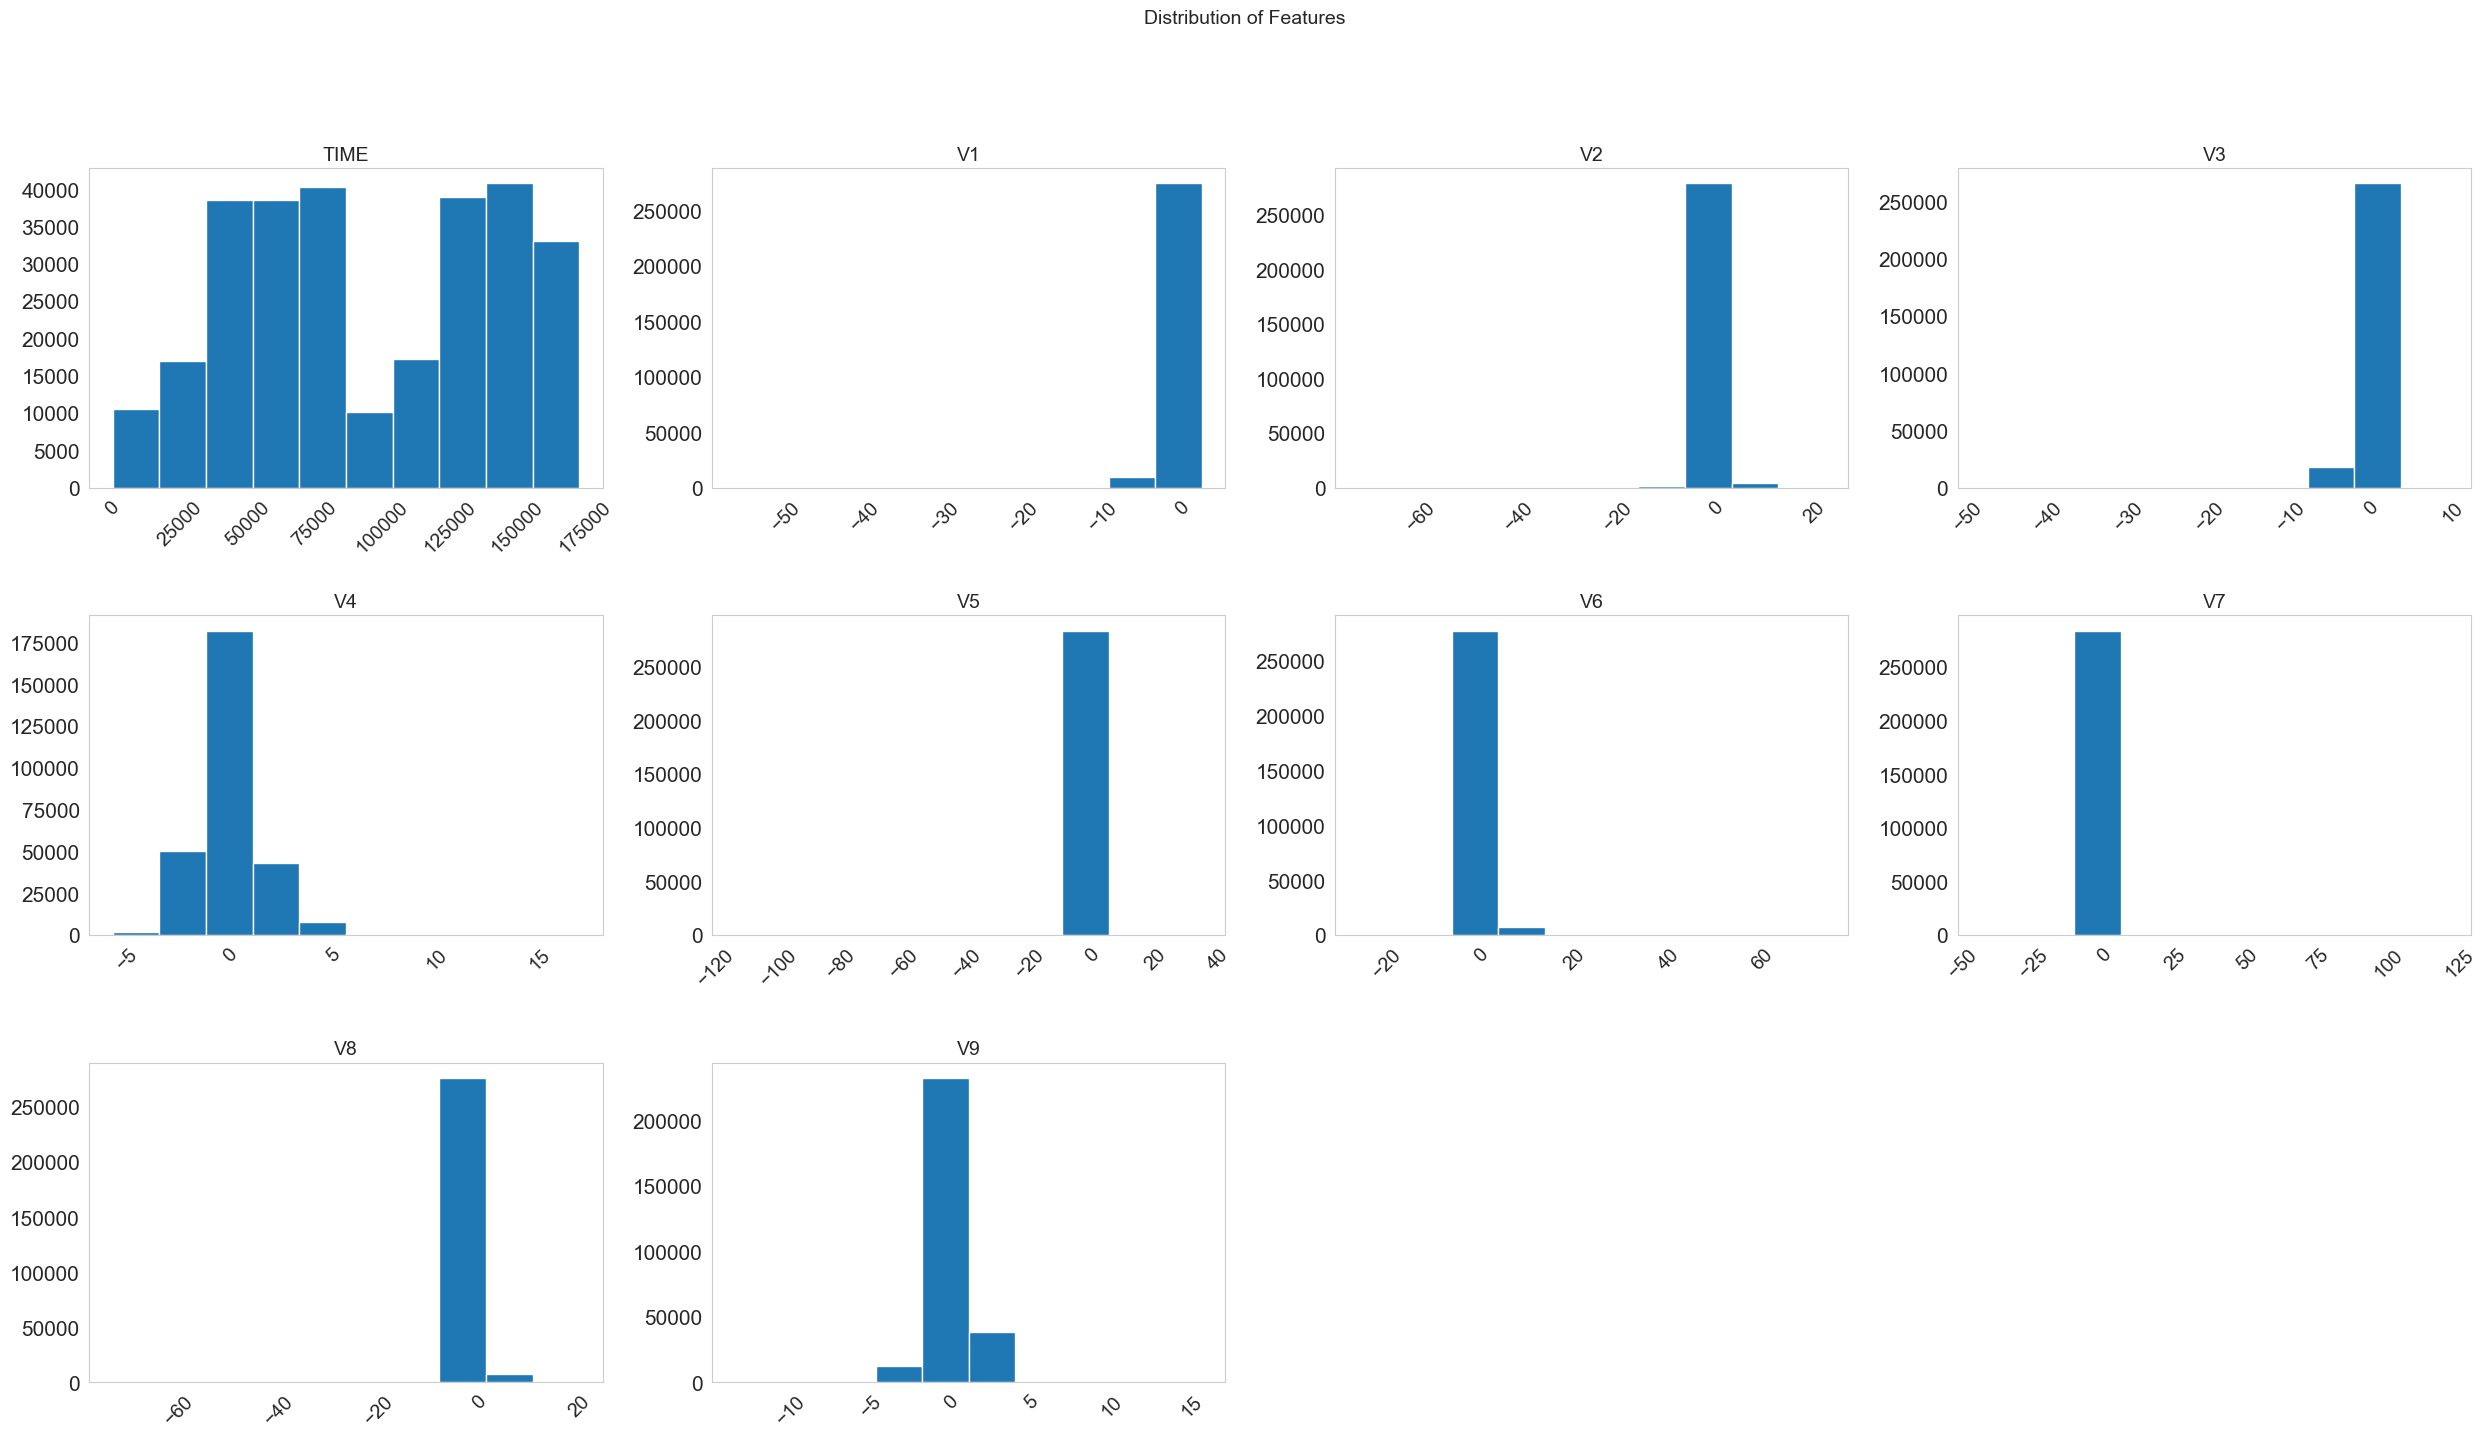

In [28]:
# create several histograms to show the distributions of the features
fig = plt.figure(figsize=(25, 15))
subtitle = fig.suptitle("Distribution of Features", fontsize=14, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1, 11)):
    ax = fig.add_subplot(3, 4, num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=14)
plt.tight_layout()
subtitle.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

By analysing these plots, we conclude that Time does not have a normal distribution and the values 75 000-100 000 seconds are the ones with less occurences throughout the dataset. All of the Vx componentes are normalized, and with most occurences centered around the value 0. These feautures also show some negative values.

## USER DEFINED FUCTIONS

Firstly lets create YES or NO values to assign to the values in our "Class" column. If the values is 1, then we assign it a "yes", and if the value is 0, then we assign it a "no". After developing the function, we also create a column called "IsFraud".

In [29]:
# create the yes/no function
y_udf = f.udf(lambda y: "no" if y == 0 else "yes", f.StringType())

In [30]:
# create the new column for the yes/no values
df = df.withColumn("IsFraud", y_udf('Class'))

df.show(5)

Py4JJavaError: An error occurred while calling o740.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 73.0 failed 1 times, most recent failure: Lost task 0.0 in stage 73.0 (TID 101) (DESKTOP-9VU4VJO.home executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:82)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 25 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4177)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3161)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4167)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:526)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4165)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4165)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3161)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3382)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:284)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:323)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:82)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 25 more


In [ ]:
# create a function to group time values
def udf_multi(time):
    if(time < 50000):
        return "Under 50K s"
    elif(time >= 50000 and time <= 100000):
        return "Between 50K and 100K s"
    elif(time > 100000):
        return "Over 100K s"
    else: return "NA"

In [ ]:
# apply the function to the "Time column"
time_udf = f.udf(udf_multi)
df = df.withColumn('time_udf', time_udf('Time'))

df.show(5)

APPLYING SOME STATISTICS

In [ ]:
from pyspark.sql import Window 
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing) 

In [ ]:
# lets create a table
time_group_table = df.select(["time_udf", "Amount"]).\
                         groupBy('time_udf').\
                            agg(
                                f.count("Amount").alias("UserCount"),
                                f.mean("Amount").alias("Amount_Avg"),
                                f.min("Amount").alias("Amount_Min"),
                                f.max("Amount").alias("Amount_Max")).\
                            withColumn("total", f.sum(f.col("UserCount")).over(window)).\
                            withColumn("Percent", f.col("UserCount")*100 / f.col("total")).\
                            drop(f.col("total")).sort(f.desc("Percent"))

In [ ]:
time_group_table.toPandas()

Here we computed some statistics with the "Amount" column, divided by the three time groups defined earlier. Now let's plot our results:

In [ ]:
sns.barplot(x="time_udf", y="Percent", data=time_group_table.toPandas())

After analysing the graph, we conclude that the largest percentage for the Amount values is found when the time between each transaction recorded is over 100 000 seconds.

In [ ]:
# All Transactions
df_aux = df.select("Class", "Amount").toPandas()

# Define amount ranges
amount_ranges = [
    {"range": "Transaction Value <= $100", "min_amount": 0, "max_amount": 100},
    {"range": "Transaction Value between \$101 and \$2000", "min_amount": 101, "max_amount": 2000},
    {"range": "Transaction Value between \$2001 and \$5000", "min_amount": 2001, "max_amount": 5000},
    {"range": "Transaction Value > $5000", "min_amount": 5001, "max_amount": df_aux["Amount"].max()}
]

# Create four subplots for different amount ranges
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for idx, amount_range in enumerate(amount_ranges):
    row_idx = idx // 2
    col_idx = idx % 2

    # Filter transactions within amount range
    df_range = df_aux[(df_aux["Amount"] > amount_range["min_amount"]) & (df_aux["Amount"] <= amount_range["max_amount"])]

    # Plot histogram
    sns.histplot(data=df_range, x="Amount", ax=axes[row_idx, col_idx], hue="Class", kde=True)
    axes[row_idx, col_idx].set_title(amount_range["range"])
    axes[row_idx, col_idx].set_ylabel("Number of Transactions")
    axes[row_idx, col_idx].legend(labels=["Fraud", "Non-Fraud"])

fig.suptitle("All Transactions", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Only fraud transactions
only_fraud = df.filter(df.Class == 1).select("Amount").toPandas()

# Add a pallet
aux_pal = ["#ff7f7f", "#ff3c3c"]

# Create three subplots for different amount ranges
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Amount range <= 100
sns.histplot(data=only_fraud[only_fraud["Amount"] <= 100], x="Amount", ax=axes[0], kde=True, color=aux_pal[0])
axes[0].set_title("Transaction Amount <= $100")
axes[0].set_ylabel("Number of Transactions")

# Amount range > 100
sns.histplot(data=only_fraud[(only_fraud["Amount"] > 100)], x="Amount", ax=axes[1], kde=True, color=aux_pal[1])
axes[1].set_title("Transaction Amount > $100")
axes[1].set_ylabel("Number of Transactions")

fig.suptitle("Only Fraudulent Transactions", fontsize=16)
plt.tight_layout()
plt.show()

Now we move on and try to do some correlation:

In [ ]:

# create a dataframe with only numeric features in order to simplify our correlactions
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()

In [ ]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

In [ ]:
# import Statistics from mllib -> Pyspark and import Pandas
from pyspark.mllib.stat import Statistics
import pandas as pd

In [ ]:
# create a correlation matrix
corr_matrix = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_matrix)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df, 2)

Since the dataset has a lot of information, it is best to do a heatmap, to facilitate visualization:

In [ ]:
# create the heatmap
sns.heatmap(corr_df)

By looking at our correlation matrix, we arrived at the following conclusions:

    The variables that were a product of PCA are not correlated with each other;
    "Time" seems to be negatively correlated with all of the "Vx" variables;
    "Time" and "Class" seem to have no correlation;
    "Class" seem to be negatively correlated with some of the "Vx" variables, and not correlated at all with others.

## 1.2 IMBALANCED DATA

In [ ]:
df1= df.toPandas()
df1= df1.sample(frac=1)

In [ ]:
# amount of fraud classes 492 rows.
fraud_df = df1.loc[df1['Class'] == 1]
non_fraud_df = df1.loc[df1['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.shape

In [ ]:
#Plot Distribution of the Classes
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot(x ='Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## 1.3 VISUALIZATION WITH BALANCED DATA

In [ ]:
#Histogram distribution
for i in new_df.loc[:, ~new_df.columns.isin(['Time','Class','IsFraud','time_udf'])]:
    plt.figure(figsize = [10,5]);
    plt.subplot(1,2,1);
    sns.histplot(new_df [i]);
    plt.title('Distribution of {} values'.format(i) , size = 14);
    plt.xlabel(i , size = 12);
    plt.ylabel("count", size = 12);
    
    plt.subplot(1,2,2);
    sns.boxplot(data = new_df, x = i);
    plt.title('{} boxplot'.format(i) , size = 14);
    plt.xlabel(i , size = 12);
    plt.ylabel("count", size = 12);
    plt.show()

In [ ]:
#Normality checking
def is_normal(x, treshhold = 0.05):
    k2,p = stats.normaltest(x)
    print(p)
    print(p > treshhold)
    print('\n')
    return p > treshhold

for name in list(new_df.loc[:, ~new_df.columns.isin(['Time','Class','IsFraud','time_udf'])]):
    is_normal(np.array(new_df[name]))

In [ ]:
# Check skeness
new_df.loc[:, ~new_df.columns.isin(['Time','Class','IsFraud','time_udf'])].skew()

In [ ]:
# Visualization of the relation between each variable and Class
x = 0
plt.figure(figsize = [18,20]);
for i in new_df.loc[:, ~new_df.columns.isin(['Time','Class','IsFraud','time_udf'])] :
    plt.subplot(8,4,x+1)
    sns.boxplot(data = new_df, x = 'Class', y = i)
    plt.title("barplot visualization between Class and {}".format(i), size = 12);
    x = x +1
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.3,  
                    hspace=0.5) 
plt.show()

In [ ]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

df1= df.toPandas()
df1= df1.sample(frac=1)
df2 = df1.loc[:, ~df1.columns.isin(['Time','IsFraud','time_udf'])]
new_df1= new_df.loc[:, ~new_df.columns.isin(['Time','IsFraud','time_udf'])]

# Entire DataFrame
corr = df2.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)


sub_sample_corr = new_df1.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix ', fontsize=14)
plt.show()

In [ ]:
print('Sorted Correlation values with Class:')
print(new_df1[new_df1.columns[1:]].corr()['Class'][:-1].sort_values())

In [ ]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

sub_sample_corr = new_df1.corr()

sns.heatmap(sub_sample_corr > 0.7, cbar=False, annot_kws={'size':20}, ax=ax1)
ax1.set_title('SubSample Correlation Matrix: Correlation > 0.7', fontsize=14)

sns.heatmap(sub_sample_corr <-0.7,  cbar=False, annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix: Correlation < -0.7', fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from collections import OrderedDict
corrs = OrderedDict([(col, pearsonr(new_df1[col], new_df1['Class'] == 1)) for col in new_df1.loc[:, ~new_df1.columns.isin(['Time','Class'])]])
corrs = pd.DataFrame(index = corrs.keys(), data={
        'corr_coef': [corr[0] for corr in corrs.values()],
        'p_value': [corr[1] for corr in corrs.values()],
    })

corrs.applymap(lambda xx : abs(xx)).sort_values(by='corr_coef', ascending=False).rename(columns={
        'corr_coef': 'absolute correlation coefficient'
    })

In [ ]:
#Bivariate Analysis
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V14", data=new_df1,  ax=axes[0])
axes[0].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=new_df1,  ax=axes[1])
axes[1].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df1, ax=axes[2])
axes[2].set_title('V10 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V16", data=new_df1, ax=axes[3])
axes[3].set_title('V16 vs Class Negative Correlation')

plt.show()

In [ ]:
#Bivariate Analysis
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V4", data=new_df1,  ax=axes[0])
axes[0].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V11", data=new_df1,  ax=axes[1])
axes[1].set_title('V11 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df1, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df1, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

In [ ]:
#Histogram distribution if is Fraud
new_df1.loc[:, ~new_df1.columns.isin(['Time','Class'])].loc[new_df['Class'] == 1].hist(bins=30, figsize=(10, 10))
plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.8) 
plt.show()

In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df1['V14'].loc[new_df1['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df1['V12'].loc[new_df1['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df1['V10'].loc[new_df1['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [ ]:
for i in new_df1.columns:
    plt.figure();
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})
    f, (ax_hist) = plt.subplots(1, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Density')
    #sns.histplot(new_df[i], ax=ax_hist ,  bins = 20, kde=True)
    sns.distplot(new_df1[i], ax=ax_hist, fit=norm, color='#FB8861')

#plt.show()

## Outliers

In [ ]:
z = np.abs(stats.zscore(new_df1.loc[:, ~new_df1.columns.isin(['Time','Class'])]))
threshold = 3
df1_new = new_df1[(z < 3).all(axis=1)]

df1_new.describe().T 

In [ ]:
new_df1.loc[:, ~new_df1.columns.isin(['Amount','Time','Class', 'IsFraud','time_udf'])].boxplot( figsize=(12,8), vert=False)
plt.title("With outliers", fontsize=14)
plt.show()

In [ ]:
df1_new.loc[:, ~df1_new.columns.isin(['Amount','Time','Class'])].boxplot( figsize=(12,8), vert=False)
plt.title("Without outliers", fontsize=14)
plt.show()

In [ ]:
# % of data removed :
print("percentage of records removed is :",(1 - (df1_new.shape[0] / new_df1.shape[0]))*100,", it is an accepted % ")

In [ ]:
#Plot Distribution of the Classes
print('Distribution of the Classes in the dataset without outliers')
print(df1_new['Class'].value_counts()/len(df1_new))

sns.countplot(x ='Class', data=df1_new)
plt.title('Balanced Classes without outliers', fontsize=14)
plt.show()

In [ ]:
# Visualization of the relation between each variable and Class in a balanced dataset without outliers
x = 0
plt.figure(figsize = [18,20]);
for i in df1_new.loc[:, ~df1_new.columns.isin(['Time','Class'])] :
    plt.subplot(8,4,x+1)
    sns.boxplot(data = df1_new, x = 'Class', y = i)
    plt.title("barplot visualization between Class and {}".format(i), size = 12);
    x = x +1
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.3,  
                    hspace=0.5) 
plt.show()

In [ ]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=df1_new,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)
# Feature 12
sns.boxplot(x="Class", y="V12", data=df1_new, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)
# Feature V10
sns.boxplot(x="Class", y="V10", data=df1_new, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)
plt.show()

## Machine Learning - É PRECISO REVER TUDO DAQUI PARA BAIXO

In [ ]:
# Importing required Spark ML lib methods

from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [ ]:
dfsp = spark.createDataFrame(new_df.loc[:, ~new_df.columns.isin(['IsFraud','time_udf'])])


In [ ]:
# Converting String data type of column to double

for column in dfsp.columns:
    data = dfsp.withColumn(column,dfsp[column].cast("double"))

In [ ]:
#Adding index to keep track of the rows even after shuffling

from pyspark.sql.functions import *
from pyspark.sql.window import Window
win = Window().orderBy('Time')
dfsp = dfsp.withColumn("idx", row_number().over(win))

In [ ]:
dfsp.head()

In [ ]:
feature_columns = [col for col in dfsp.columns if col.startswith("V")]
print(feature_columns)

In [ ]:
vectorizer = VectorAssembler(inputCols = feature_columns, outputCol="features")
vectorizer.transform(df).select("features", "Class").limit(5).toPandas()

In [ ]:
est = RandomForestClassifier()
est.setMaxDepth(5)
est.setLabelCol("Class")

In [ ]:
print(est.explainParams())

In [ ]:
# Importing required Spark ML lib methods

from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [ ]:
# Converting the feature columns to dense vector (required by spark) and creating label and index columns

training_df = dfsp.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31]))

In [ ]:
training_df = spark.createDataFrame(training_df,["features","label","index"])

In [ ]:
training_df = training_df.select("index","features","label")

In [ ]:
# Splitting data into training and testing data

train_data, test_data = training_df.randomSplit([.8,.2],seed=1234)

In [ ]:
train_data.groupBy("label").count().show()

In [ ]:
test_data.groupBy("label").count().show()

In [ ]:
df_train, df_test = df.randomSplit(weights=[0.7, 0.3], seed = 1)

In [ ]:
pipeline = Pipeline()
pipeline.setStages([vectorizer, est])
model = pipeline.fit(df_train)

In [ ]:

df_test_pred = model.transform(df_test)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol("Class")

In [ ]:
evaluator.evaluate(model.transform(df_test))

In [ ]:
from pyspark.sql.functions import *

In [ ]:
test_accuracy = (df_test_pred
                 .select("Class", "prediction")
                 .withColumn("isEqual", expr("Class == prediction"))
                 .select(avg(expr("cast(isEqual as float)")))
                 .first())

In [ ]:
test_accuracy

In [ ]:
treeEstimator = DecisionTreeClassifier()
treeEstimator.setImpurity("entropy")
treeEstimator.setLabelCol("Class")

pipeline = Pipeline()
pipeline.setStages([vectorizer, treeEstimator])
model = pipeline.fit(df_train)
evaluator.evaluate(model.transform(df_test))

In [ ]:
accuracy_evaluator = MulticlassClassificationEvaluator()
accuracy_evaluator.setLabelCol("Class")
accuracy_evaluator.setMetricName("accuracy")
accuracy_evaluator.evaluate(model.transform(df_test))

In [ ]:
f1_evaluator = MulticlassClassificationEvaluator()
f1_evaluator.setLabelCol("Class")
f1_evaluator.setMetricName("f1")
f1_evaluator.evaluate(model.transform(df_test))

## Gradient Boosting Trees Classifier Model

In [ ]:
# Creating Gradient Boosting Trees Classifier Model to fit and predict data

gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=8)
model = gbt.fit(train_data)
predictions = model.transform(test_data)

In [ ]:
# Checking the count of records classified into each classes

predictions.groupBy("prediction").count().show()

In [ ]:
# Calculating accuracy of model

evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

In [ ]:
# Calculating percentage of fraud records predicted correctly

predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))
predictions.groupBy("fraudPrediction").count().show()

In [ ]:
predictions.groupBy("label").count().show()

In [ ]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100
print("Fraud Prediction Accuracy: ",FraudPredictionAccuracy)

In [ ]:
# Calculating Confusion matrix

tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)
print("Recall: ",tp/(tp+fn))
print("Precision: ", tp/(tp+fp))
print("F1 Score",  (2 * (tp/(tp+fp)) * (tp/(tp+fn)) /((tp/(tp+fp)) + (tp/(tp+fn)))))